# EEG Signals Classification

These files contain processed data from a psychology experiment measuring brain response when a subject pays attention to a sudden visual stimulus and when they do not.

- The first column corresponds to the class (1 or 2).
- Class 1 represents when the subject is paying attention (P300), and class 2 when they are not (non-P300).
- The second column is to be ignored, while the rest of the columns represent variables calculated from the brain response measured using Electroencephalography (EEG) techniques for each case.

In [1]:
import numpy as np
import pandas as pd

df_txt = np.loadtxt("data/P1_5.txt")
df = pd.DataFrame(df_txt)
df.drop(columns = 1, inplace = True)

In [2]:
df.head()

,0,2,3,4,5,6,7,8,9,10,...,145,146,147,148,149,150,151,152,153,154
0,1.0,6.778645,5.554810,4.935933,5.639114,6.603463,6.309278,4.738829,3.110043,2.167682,...,0.129900,-0.609716,-0.822197,-0.109120,0.899585,1.374105,1.187913,0.742605,0.347446,0.131211
1,1.0,-0.354725,-0.210143,-0.337065,-0.613978,-0.725109,-0.509282,-0.154146,0.062651,0.102172,...,-0.468649,-0.052648,0.544180,0.781654,0.833143,1.253793,1.914558,2.013101,1.287430,0.521264
2,1.0,1.727716,2.056163,1.876898,0.992565,0.224456,0.429907,1.229387,1.403841,0.507216,...,-0.365350,-0.827163,0.208835,1.473647,1.545710,0.672175,0.097850,0.288585,0.679454,0.822155
3,1.0,1.064721,1.299112,0.705400,0.422355,1.269587,2.672225,3.240471,2.234018,0.275905,...,0.026794,-0.726883,-0.768780,-0.600054,-0.948638,-1.688718,-1.858080,-0.862087,0.660512,1.426284
4,1.0,-0.010284,-0.097968,-0.345274,-0.216691,0.351261,0.781839,0.695825,0.298840,-0.198690,...,1.946469,0.730151,-0.396311,-0.324040,0.629645,1.199808,0.600917,-0.806892,-2.087005,-2.579933


In [3]:
X = df.drop(columns = 0)
y = df.loc[:,0] - 1 # For simplicity in future model training
y = y.replace({0: 1, 1: 0})

### Handle imbalanced dataset

In [4]:
notP300_count = len(y[y == 0])
P300_count = len(y[y == 1])
(notP300_count, P300_count)

(1689, 281)

In [5]:
prior_0 = len(y[y == 0]) / len(y)
prior_1 = len(y[y == 1]) / len(y)
(prior_0, prior_1)

(0.8573604060913705, 0.14263959390862943)

#### Indeed, the dataset is imbalanced. More than 85% of the samples are labeled as non-P300, and less than 15% are labeled as P300.

In [52]:
# Eight Classifiers
from sklearn.svm import SVC # Linear and RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier

# Cross-validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
import random

### Here's a function in Python to evaluate a model using cross-validation. It handles class imbalance by applying subsampling and uses weighted loss if the model includes this option in sklearn. The function can take any classifier model as input, apply cross-validation, and manage imbalance through either subsampling or a weighted loss function.

In [7]:
def evaluate_model(X, y, classifier, balance_param_name=None, balance_param_value=None):
    """
    Función para evaluar modelos utilizando validación cruzada, aplicando subsampling 
    y, si es aplicable, incluir un parámetro personalizado para manejar desbalanceo de datos.

    Parámetros:
    X (pd.DataFrame): Características
    y (pd.Series): Etiquetas
    classifier: Modelo clasificador a evaluar
    balance_param_name (str): Nombre del parámetro para manejar desbalanceo (ej: 'class_weight')
    balance_param_value (any): Valor del parámetro de desbalanceo (ej: 'balanced')

    Retorna:
    None: Imprime el reporte de clasificación de la validación cruzada.
    """

    # Validación cruzada
    kf = StratifiedKFold(n_splits=5, shuffle=True)
    
    cv_y_test = []
    cv_y_pred = []

    # Aplicamos subsampling en cada pliegue
    for train_index, test_index in kf.split(X, y):
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]

        # Subsampling: balancear las clases haciendo muestreo aleatorio de la clase mayoritaria
        X1 = X_train[y_train == 0]  # Datos de la clase 1
        y1 = y_train[y_train == 0]
        n1 = len(y1)

        X2 = X_train[y_train == 1]  # Datos de la clase 2
        y2 = y_train[y_train == 1]
        n2 = len(y2)

        

        # Muestreo aleatorio de la clase mayoritaria
        ind = random.choices(list(X2.index), k=n1)  # Igualar el número de muestras
        X_sub = pd.concat([X1, X2.loc[ind]])
        y_sub = pd.concat([y1, y2.loc[ind]])

        # Entrenar el modelo con subsampling
        classifier.fit(X_sub, y_sub)

        # Fase de prueba
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]
        y_pred = classifier.predict(X_test)

        # Guardar predicciones y etiquetas reales
        cv_y_test.append(y_test)
        cv_y_pred.append(pd.Series(y_pred, index=y_test.index))

    # Concatenar predicciones y etiquetas
    y_test_concat = pd.concat(cv_y_test)
    y_pred_concat = pd.concat(cv_y_pred)

    # Imprimir reporte de clasificación con subsampling
    print(f"--- Reporte de clasificación con subsampling ---")
    print(classification_report(y_test_concat, y_pred_concat))

    # Evaluación adicional con un parámetro de balanceo (si se ha proporcionado)
    if balance_param_name and balance_param_value:
        # Crear una copia del clasificador con el parámetro de balanceo aplicado
        classifier_with_balance = classifier.set_params(**{balance_param_name: balance_param_value})

        cv_y_test_balanced = []
        cv_y_pred_balanced = []

        for train_index, test_index in kf.split(X, y):
            # Entrenamos el modelo con el parámetro de balanceo sin subsampling
            X_train = X.iloc[train_index]
            y_train = y.iloc[train_index]
            classifier_with_balance.fit(X_train, y_train)

            # Fase de prueba
            X_test = X.iloc[test_index]
            y_test = y.iloc[test_index]
            y_pred_balanced = classifier_with_balance.predict(X_test)

            # Guardar predicciones y etiquetas reales
            cv_y_test_balanced.append(y_test)
            cv_y_pred_balanced.append(pd.Series(y_pred_balanced, index=y_test.index))

        # Concatenar predicciones y etiquetas
        y_test_concat_balanced = pd.concat(cv_y_test_balanced)
        y_pred_concat_balanced = pd.concat(cv_y_pred_balanced)

        # Imprimir reporte de clasificación con el parámetro de balanceo
        print(f"--- Reporte de clasificación con {balance_param_name}={balance_param_value} ---")
        print(classification_report(y_test_concat_balanced, y_pred_concat_balanced))

### K-Nearest-Neighbors

In [8]:
evaluate_model(X, y, KNeighborsClassifier(n_neighbors=5))

--- Reporte de clasificación con subsampling ---
              precision    recall  f1-score   support

         0.0       0.93      0.80      0.86      1689
         1.0       0.35      0.64      0.45       281

    accuracy                           0.78      1970
   macro avg       0.64      0.72      0.66      1970
weighted avg       0.85      0.78      0.80      1970



### Linear Discriminant Analysis

In [9]:
evaluate_model(X, y, LinearDiscriminantAnalysis(), balance_param_name='priors', balance_param_value=[prior_0, prior_1])

--- Reporte de clasificación con subsampling ---
              precision    recall  f1-score   support

         0.0       0.97      0.88      0.92      1689
         1.0       0.53      0.83      0.65       281

    accuracy                           0.87      1970
   macro avg       0.75      0.85      0.78      1970
weighted avg       0.91      0.87      0.88      1970

--- Reporte de clasificación con priors=[0.8573604060913705, 0.14263959390862943] ---
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95      1689
         1.0       0.76      0.63      0.69       281

    accuracy                           0.92      1970
   macro avg       0.85      0.80      0.82      1970
weighted avg       0.91      0.92      0.92      1970



### Gaussian Naive-Bayes

In [10]:
evaluate_model(X, y, GaussianNB(), balance_param_name='priors', balance_param_value=[prior_0, prior_1])

--- Reporte de clasificación con subsampling ---
              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92      1689
         1.0       0.48      0.35      0.41       281

    accuracy                           0.85      1970
   macro avg       0.69      0.64      0.66      1970
weighted avg       0.84      0.85      0.84      1970

--- Reporte de clasificación con priors=[0.8573604060913705, 0.14263959390862943] ---
              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91      1689
         1.0       0.40      0.25      0.31       281

    accuracy                           0.84      1970
   macro avg       0.64      0.59      0.61      1970
weighted avg       0.81      0.84      0.82      1970



### Linear Support Vector Classifier

In [11]:
evaluate_model(X, y, SVC(kernel='linear'), balance_param_name='class_weight', balance_param_value='balanced')

--- Reporte de clasificación con subsampling ---
              precision    recall  f1-score   support

         0.0       0.97      0.89      0.92      1689
         1.0       0.54      0.81      0.65       281

    accuracy                           0.87      1970
   macro avg       0.75      0.85      0.79      1970
weighted avg       0.90      0.87      0.88      1970

--- Reporte de clasificación con class_weight=balanced ---
              precision    recall  f1-score   support

         0.0       0.97      0.88      0.92      1689
         1.0       0.54      0.81      0.65       281

    accuracy                           0.87      1970
   macro avg       0.75      0.85      0.78      1970
weighted avg       0.90      0.87      0.88      1970



### Radial Support Vector Classifier

In [13]:
evaluate_model(X, y, SVC(kernel='rbf'), balance_param_name='class_weight', balance_param_value='balanced')

--- Reporte de clasificación con subsampling ---
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95      1689
         1.0       0.68      0.78      0.73       281

    accuracy                           0.92      1970
   macro avg       0.82      0.86      0.84      1970
weighted avg       0.92      0.92      0.92      1970

--- Reporte de clasificación con class_weight=balanced ---
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95      1689
         1.0       0.66      0.79      0.72       281

    accuracy                           0.91      1970
   macro avg       0.81      0.86      0.83      1970
weighted avg       0.92      0.91      0.91      1970



### Desicion Tree

In [14]:
evaluate_model(X, y, DecisionTreeClassifier(), balance_param_name='class_weight', balance_param_value='balanced')

--- Reporte de clasificación con subsampling ---
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.91      1689
         1.0       0.49      0.51      0.50       281

    accuracy                           0.85      1970
   macro avg       0.70      0.71      0.71      1970
weighted avg       0.86      0.85      0.86      1970

--- Reporte de clasificación con class_weight=balanced ---
              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91      1689
         1.0       0.46      0.44      0.45       281

    accuracy                           0.85      1970
   macro avg       0.68      0.68      0.68      1970
weighted avg       0.84      0.85      0.84      1970



### Random Forest

In [15]:
evaluate_model(X, y, RandomForestClassifier(), balance_param_name='class_weight', balance_param_value='balanced')

--- Reporte de clasificación con subsampling ---
              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94      1689
         1.0       0.88      0.34      0.49       281

    accuracy                           0.90      1970
   macro avg       0.89      0.67      0.72      1970
weighted avg       0.90      0.90      0.88      1970

--- Reporte de clasificación con class_weight=balanced ---
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93      1689
         1.0       0.88      0.18      0.30       281

    accuracy                           0.88      1970
   macro avg       0.88      0.59      0.61      1970
weighted avg       0.88      0.88      0.84      1970



### XGBoost

In [16]:
evaluate_model(X, y, XGBClassifier(), balance_param_name='scale_pos_weight', balance_param_value=len(y[y == 0])/len(y[y == 1]))

--- Reporte de clasificación con subsampling ---
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95      1689
         1.0       0.78      0.62      0.69       281

    accuracy                           0.92      1970
   macro avg       0.86      0.80      0.82      1970
weighted avg       0.92      0.92      0.92      1970

--- Reporte de clasificación con scale_pos_weight=6.01067615658363 ---
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95      1689
         1.0       0.78      0.60      0.68       281

    accuracy                           0.92      1970
   macro avg       0.86      0.79      0.82      1970
weighted avg       0.91      0.92      0.91      1970



### Logistic Regression from Scratch

In [24]:
# Sigmoid Function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class LogisticRegression:
    
    def __init__(self, lr=0.001, n_iters=1000):
        self.lr = lr #Learning rate
        self.n_iters = n_iters #Number of epochs
        self.weights = None # Weights
        self.bias = None # Bias
        
    def fit(self, X, y):
        # Define key variables
        n_samples, n_features = X.shape
        
        #Initialize weights and bias with zeros
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        # Train the model for n_iters times
        for _ in range(self.n_iters):
            # Get predictions
            linear_pred = np.dot(X, self.weights) + self.bias # y = mx + b
            predictions = sigmoid(linear_pred) # fit our linear predictions into the sigmoid function
            
            # Calculate the Gradients
            dw = (1 / n_samples) * np.dot(X.T, (predictions - y))
            db = (1 / n_samples) * np.sum(predictions - y)
    
            # Compute new weights and biases
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        linear_pred = np.dot(X, self.weights) + self.bias # y = mx + b
        y_pred = sigmoid(linear_pred) # fit our linear predictions into the sigmoid functio
        class_pred = [0 if y <= 0.5 else 1 for y in y_pred] # assign a class to our predictions
        return np.array(class_pred)

In [25]:
evaluate_model(X, y, LogisticRegression())

--- Reporte de clasificación con subsampling ---
              precision    recall  f1-score   support

         0.0       0.99      0.66      0.79      1689
         1.0       0.32      0.96      0.48       281

    accuracy                           0.71      1970
   macro avg       0.66      0.81      0.64      1970
weighted avg       0.89      0.71      0.75      1970



### Best model: Radial Support Vector Classifier with weight loss function

This model was chosen because it has a good recall for the minority class (0.79), indicating that it detected almost 80% of the P300 signals. Additionally, it has the highest F1-score for the minority class (0.72) among all the evaluated models, which indicates the best balance between recall and precision for this class. Finally, it achieved an accuracy of 0.91.

However, this model is not recommended for some feature selection methods. In fact, only filter methods are advised since they do not require model training prior to feature selection. Therefore, other models will be used for the remaining methods. For sequential feature selection, Linear Discriminant Analysis will be employed, and for Recursive Feature Elimination (RFE), Linear SVC will be used.

### Feature Selection: Filter method

Optimal number of features:  128
F1-Score (class 1) with optimal number of features:  0.740192737478181


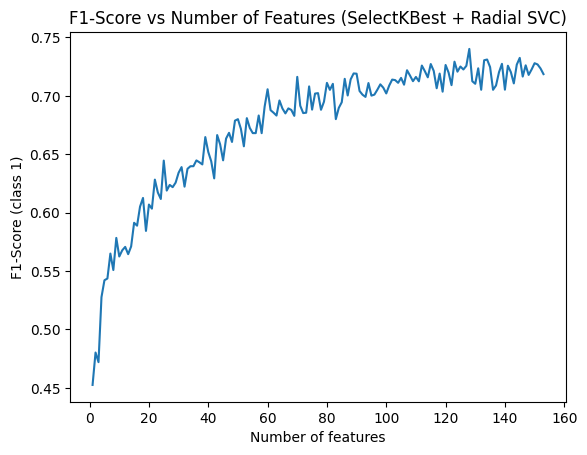

In [42]:
n_feats = range(1, len(X.columns)+1)
f1_nfeat = []

kf = StratifiedKFold(n_splits=5, shuffle=True)

for n_feat in n_feats:
    
    f1_cv = []

    for train_index, test_index in kf.split(X, y):
        # Training phase
        X_train = X.iloc[train_index, :]
        y_train = y.iloc[train_index]

        # Define classifier with Radial kernel
        clf_cv = SVC(kernel='rbf', class_weight = 'balanced')

        # Feature selection with SelectKBest
        fselection_cv = SelectKBest(f_classif, k=n_feat)
        fselection_cv.fit(X_train, y_train)
        X_train_selected = fselection_cv.transform(X_train)

        # Train classifier
        clf_cv.fit(X_train_selected, y_train)

        # Test phase
        X_test_selected = fselection_cv.transform(X.iloc[test_index, :])
        y_test = y.iloc[test_index]
        y_pred = clf_cv.predict(X_test_selected)

        # Calculate f1-score for class 1
        f1_i = f1_score(y_test, y_pred, pos_label=1)
        f1_cv.append(f1_i)

    # Average f1-score for this number of features
    f1_avg = np.average(f1_cv)
    f1_nfeat.append(f1_avg)

# Find optimal number of features
opt_index = np.argmax(f1_nfeat)
opt_features = n_feats[opt_index]
opt_f1_score = f1_nfeat[opt_index]
print("Optimal number of features: ", opt_features)
print("F1-Score (class 1) with optimal number of features: ", opt_f1_score)

# Plot f1-score vs number of features
plt.plot(n_feats, f1_nfeat)
plt.xlabel("Number of features")
plt.ylabel("F1-Score (class 1)")
plt.title("F1-Score vs Number of Features (SelectKBest + Radial SVC)")
plt.show()

### Feature Selection: Sequential method

In [44]:
from sklearn.feature_selection import SequentialFeatureSelector

In [ ]:
n_feats = range(1, len(X.columns)+1)
f1_nfeat = []

kf = StratifiedKFold(n_splits=5, shuffle=True)

for n_feat in n_feats:

    
    f1_cv = []

    for train_index, test_index in kf.split(X, y):
        # Training phase
        X_train = X.iloc[train_index, :]
        y_train = y.iloc[train_index]

        # Define LDA classifier
        clf_cv = LinearDiscriminantAnalysis(priors=[prior_0, prior_1])

        # Sequential Feature Selector
        fselection_cv = SequentialFeatureSelector(clf_cv, n_features_to_select=n_feat, direction='forward', cv=3)
        fselection_cv.fit(X_train, y_train)
        X_train_selected = fselection_cv.transform(X_train)

        # Train classifier
        clf_cv.fit(X_train_selected, y_train)

        # Test phase
        X_test_selected = fselection_cv.transform(X.iloc[test_index, :])
        y_test = y.iloc[test_index]
        y_pred = clf_cv.predict(X_test_selected)

        # Calculate f1-score for class 1
        f1_i = f1_score(y_test, y_pred, pos_label=1)
        f1_cv.append(f1_i)
        

    # Average f1-score for this number of features
    f1_avg = np.average(f1_cv)
    f1_nfeat.append(f1_avg)
    

# Find optimal number of features
opt_index = np.argmax(f1_nfeat)
opt_features = n_feats[opt_index]
opt_f1_score = f1_nfeat[opt_index]

print("Optimal number of features: ", opt_features)
print("F1-Score (class 1) with optimal number of features: ", opt_f1_score)

# Plot f1-score vs number of features
plt.plot(n_feats, f1_nfeat)
plt.xlabel("Number of features")
plt.ylabel("F1-Score (class 1)")
plt.title("F1-Score vs Number of Features (Sequential Feature Selector + LDA)")
plt.show()

### Feature Selection: RFE method

In [48]:
from sklearn.feature_selection import RFE

In [ ]:
# Inicialización de variables
n_feats = range(1, len(X.columns)+1)
f1_nfeat = []

kf = StratifiedKFold(n_splits=5, shuffle=True)

for n_feat in n_feats:
    
    print(f'---- n features = {n_feat}')
    
    f1_cv = []

    for train_index, test_index in kf.split(X, y):
        # Fase de entrenamiento
        X_train = X.iloc[train_index, :]
        y_train = y.iloc[train_index]

        # Definir clasificador con kernel lineal
        clf_cv = SVC(kernel='linear', class_weight='balanced')

        # Selección de características con RFE
        rfe_cv = RFE(estimator=clf_cv, n_features_to_select=n_feat)
        rfe_cv.fit(X_train, y_train)
        X_train_selected = rfe_cv.transform(X_train)

        # Entrenar clasificador
        clf_cv.fit(X_train_selected, y_train)

        # Fase de prueba
        X_test_selected = rfe_cv.transform(X.iloc[test_index, :])
        y_test = y.iloc[test_index]
        y_pred = clf_cv.predict(X_test_selected)

        # Calcular f1-score para la clase 1
        f1_i = f1_score(y_test, y_pred, pos_label=1)
        f1_cv.append(f1_i)

    # F1-score promedio para esta cantidad de características
    f1_avg = np.average(f1_cv)
    f1_nfeat.append(f1_avg)
    
    print(f'F1-Score (class 1): {f1_avg}')

# Encontrar el número óptimo de características
opt_index = np.argmax(f1_nfeat)
opt_features = n_feats[opt_index]
opt_f1_score = f1_nfeat[opt_index]
print("Optimal number of features: ", opt_features)
print("F1-Score (class 1) with optimal number of features: ", opt_f1_score)

# Graficar f1-score vs número de características
plt.plot(n_feats, f1_nfeat)
plt.xlabel("Number of features")
plt.ylabel("F1-Score (class 1)")
plt.title("F1-Score vs Number of Features (RFE + Linear SVC)")
plt.show()

### Final Model: Radial SVC with 128 features

In [50]:
# Selección de las 128 mejores características
num_features = 128
fselection = SelectKBest(f_classif, k=num_features)
X_selected = fselection.fit_transform(X, y)

In [ ]:
# Definir clasificador con kernel radial (RBF)
clf = SVC(kernel='rbf', class_weight='balanced')

In [ ]:
# Entrenar el clasificador con todos los datos
clf.fit(X_selected, y)

In [ ]:
# Guardar el modelo en un archivo pickle
'''
with open('radial_svc_model.pkl', 'wb') as model_file:
    pickle.dump(clf, model_file)

print("Modelo Radial SVC guardado en 'radial_svc_model.pkl'")
'''

### Answer the following questions:

- **What happens if the issue of imbalanced data is not considered in this case? Why?** If the classes in the dataset are not balanced when training a machine learning model, we will end up with a model that fails to classify the minority class. This will result in a model that shows very good accuracy but poor recall for the minority class.

- **Of all the classifiers, which do you consider suitable for the data? What properties do these models have that make them appropriate? Justify your answer.** Two of the top three models were linear: Linear Discriminant Analysis (LDA) and Linear SVC. However, the best model was Radial SVC, which is computationally expensive but capable of mapping a nonlinear hyperplane that accurately classifies observations from different classes.

- **Is it possible to reduce the dimensionality of the problem without losing performance in the model? Why?** Yes, it is possible to reduce dimensionality using both feature selection and dimensionality reduction methods. This is because, with so many features, some may not contribute valuable information due to issues like collinearity. Therefore, it is possible to eliminate these features or create a smaller number of new features that account for a high percentage of the variance explained in the target variable.

- **Which feature selection method do you consider most suitable for this case? Why?** I believe that the filter method is the best due to its significantly lower computational cost compared to the other two methods.

- **If you wanted to improve the performance of your models, what else could be done?** Hyperparameter tuning could be performed on the best models to find the optimal hyperparameters.